<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [166]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [167]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

In [168]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

## PRE-PROCESSING

#### Remove non-residential housing

In [169]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [170]:
house = house[house.MSZoning != 'C (all)']

### Handle null values

In [171]:
# Features with more than 30% missing values will be dropped

total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
PoolQC,1443,0.995172
MiscFeature,1398,0.964138
Alley,1361,0.938621
Fence,1172,0.808276
FireplaceQu,681,0.469655
LotFrontage,259,0.178621
GarageCond,79,0.054483
GarageType,79,0.054483
GarageYrBlt,79,0.054483
GarageFinish,79,0.054483


In [172]:
house.drop(['Alley', 'PoolQC', "MiscFeature", "Fence", "FireplaceQu"], axis=1, inplace=True)

In [173]:
house['LotFrontage'].describe()

count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

#### Lot Frontage

In [174]:
# Lot Frontage values seem normally distributed (mean and median are very similar)
# Impute with the median value.
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace = True)

#### Garage

In [175]:
filter_col = [col for col in house if col.startswith('Garage')]
Garage = house[filter_col]
Garage.isnull().sum()

GarageType      79
GarageYrBlt     79
GarageFinish    79
GarageCars       0
GarageArea       0
GarageQual      79
GarageCond      79
dtype: int64

In [176]:
Garage[Garage["GarageYrBlt"].isnull()].head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN


In [177]:
Garage[Garage["GarageYrBlt"].isnull() & Garage["GarageArea"] > 0]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond


In [178]:
# Garage Area is 0 for all NaN values, indicating that there is no garage, hence there is no GarageYrBuilt to inpute for these rows.
# I will replace the null values with "NA".

house["GarageYrBlt"].fillna('NA', inplace=True)
house["GarageQual"].fillna('NA', inplace=True)
house["GarageFinish"].fillna('NA', inplace=True)
house["GarageType"].fillna('NA', inplace=True)
house["GarageCond"].fillna('NA', inplace=True)

#### Basement

In [179]:
filter_col = [col for col in house if col.startswith('Bsmt')]
Basement = house[filter_col]
Basement[Basement["BsmtExposure"].isnull()].sum()

BsmtFinSF1        0
BsmtFinSF2        0
BsmtUnfSF       936
BsmtFullBath      0
BsmtHalfBath      0
dtype: int64

In [180]:
Basement[Basement["BsmtExposure"].isnull()].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0


In [181]:
Basement[Basement["BsmtExposure"].isnull() & Basement["BsmtFinSF1"] > 0]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath


In [182]:
# All Bsmt columns have the same rows with NaN values. 
# Basement Square Feet columns are 0, indicating that the house does not have a basement. 
# I will replace the NaN values with "NA".
#df_renovatable[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]].fillna('NA', inplace=True)

house["BsmtQual"].fillna('NA', inplace=True)
house['BsmtExposure'].fillna('NA', inplace=True)
house['BsmtFinType2'].fillna('NA', inplace=True)
house['BsmtFinType1'].fillna('NA', inplace=True)
house['BsmtCond'].fillna('NA', inplace=True)
house['BsmtQual'].fillna('NA', inplace=True)

#### Mason Veneer Type and Area

In [183]:
house['MasVnrArea'].describe()

count    1442.000000
mean      104.404300
std       181.486539
min         0.000000
25%         0.000000
50%         0.000000
75%       166.750000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [184]:
# Inpute null values with 0 as there are already MasVnrArea with 0 values
house['MasVnrArea'].fillna(0, inplace=True)

In [185]:
# There is already a category called "None" for MsnVnrType, so I will inpute NaN values with "None"
house["MasVnrType"].fillna('None', inplace=True)

#### Electrical

In [186]:
house["Electrical"].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [187]:
# Inpute mode of values of Electrical column
house["Electrical"].fillna(house["Electrical"].mode()[0], inplace=True)

In [188]:
house.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch   

In [189]:
house.shape

(1450, 76)

## FEATURE SELECTION

### Pearson Correlation 

In [190]:
def triangle_heat_map(df):
    fix, ax = plt.subplots(figsize=(16,16))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot=True, square=True)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    plt.show()

In [191]:
features = house._get_numeric_data()
features.shape

(1450, 37)

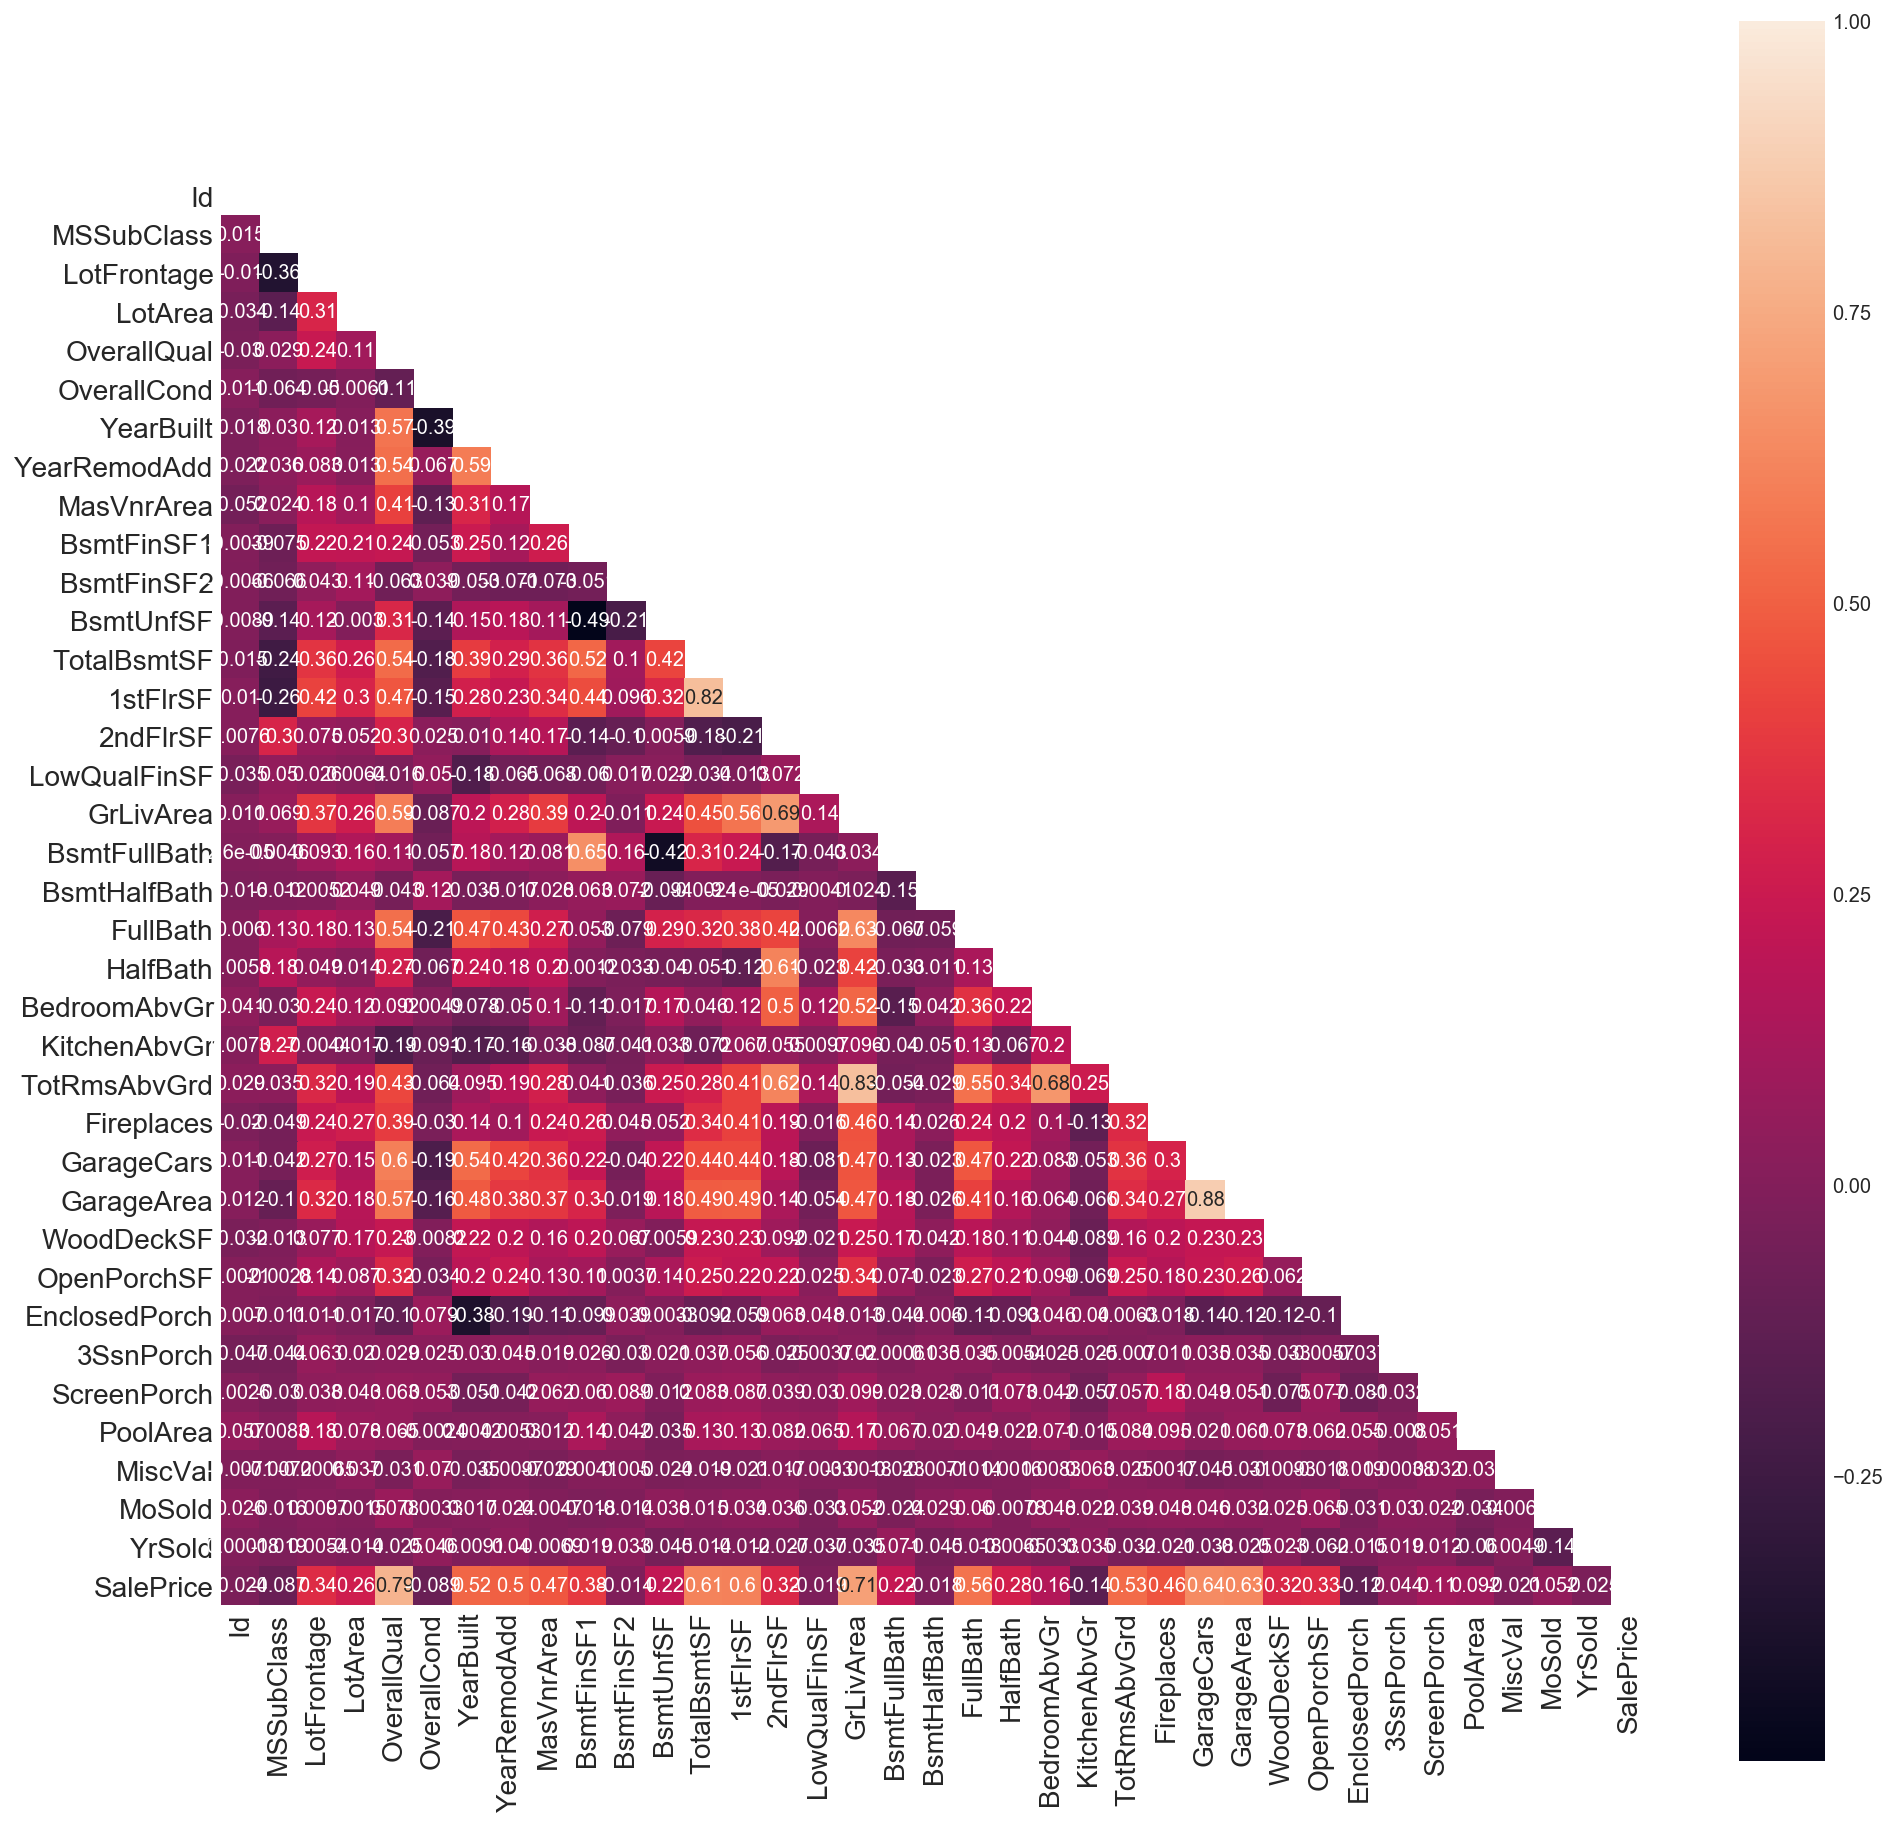

In [192]:
triangle_heat_map(features)

- The top fixed features that are well correlated sith sales prrice are GrLivArea, GarageArea, TotalBsmtSD, 1stFlrSF
- GarageYrBlt and YearBlt are highly correlated with each other. We will drop GarageYrBlt because it seems to be correlated with more columns
- 1stFlrSF and TotalBsmtSF are highly correlated with each other.  We will drop TotalBsmtFt because it seems to be correlated with more columns

 - Overall quality is highly correlated with Sale price
 - BedroomAbvGr is quite highly correlated with TotRmsAbvGrd. I will drop TotRmsAbvGrd because it seems to be more correlated to the other columns as compared to BedroomAbvGr

### Check for columns with zero variance

In [193]:
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 5):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (float(len(counts)) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (float(len(counts)) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

In [194]:
X = house.drop('SalePrice', axis=1)
zeroVar, nzVar = nearZeroVariance(X)
print zeroVar, nzVar

[] ['3SsnPorch', 'Utilities', 'BsmtCond', 'MiscVal', 'KitchenAbvGr', 'LandSlope', 'PoolArea', 'Heating', 'BsmtFinType2', 'Condition2', 'LandContour', 'RoofMatl', 'Functional', 'Street', 'LowQualFinSF']


In [195]:
house.drop(['3SsnPorch', 'Condition2', 'LandSlope', 'LandContour', 'PoolArea', 'Street', 'LowQualFinSF', 
         'GarageYrBlt', 'TotalBsmtSF', 'Utilities', 'BsmtCond', 'MiscVal', 'KitchenAbvGr', 'Heating', 
         'RoofMatl', 'BsmtFinType2', 'Functional', 'TotRmsAbvGrd'], axis=1, inplace=True)
house.shape

(1450, 58)

In [196]:
house = house.rename(columns={'1stFlrSF': 'FlrSF1', '2ndFlrSF': 'FlrSF2'}) 
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'LotShape', u'LotConfig', u'Neighborhood', u'Condition1', u'BldgType',
       u'HouseStyle', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'RoofStyle', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation',
       u'BsmtQual', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'HeatingQC', u'CentralAir', u'Electrical',
       u'FlrSF1', u'FlrSF2', u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath',
       u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenQual',
       u'Fireplaces', u'GarageType', u'GarageFinish', u'GarageCars',
       u'GarageArea', u'GarageQual', u'GarageCond', u'PavedDrive',
       u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch', u'ScreenPorch',
       u'MoSold', u'YrSold', u'SaleType', u'SaleCondition', u'SalePrice'],
      dtype='object')

In [197]:
# RENOVATABLE:
renovatable_cols = list(set(["LotConfig", "OverallQual", "OverallCond", "RoofStyle", "RoofMatl", 
                    "Exterior1st", "Exterior2nd", "MasVnrType", "MasVnrArea", "ExterQual", "ExterCond", 
                    "BsmtCond","BsmtQual", "BsmtExposure", "BsmtFinType1", 
                    "Heating", "HeatingQC", "CentralAir", "Electrical",
                    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr",
                    "KitchenQual", "Fireplaces", "GarageType", "GarageFinish", "GarageCars", "GarageQual",
                    "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "MiscVal", 'SalePrice'])
                    )
# NON-RENOVATABLE
non_renovatable_cols = list(set(["MSSubClass", "MSZoning", "LotFrontage", "LotArea", "LotShape",
                        "LandContour", "LandSlope", "Neighborhood", "Condition1", "BldgType",
                       "HouseStyle", "YearBuilt", "YearRemodAdd", "Foundation", "BsmtFinSF1", "BsmtFinSF2", 
                        "BsmtUnfSF", "FlrSF1", "FlrSF2", "GrLivArea", "GarageYrBlt","GarageArea", "WoodDeckSF",
                        "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "MoSold", "YrSold", 'SalePrice'])
                        )


# Id, SaleType and SaleCondition will be removed because they do not influence the housing price

In [198]:
#Subset dataframe to only contain non_renovatable columns + SalePrice
df = house.loc[:, house.columns.isin(non_renovatable_cols)]
df.shape

(1450, 26)

In [199]:
# Subset dataframe to only contain renovatable columns + SalePrice
df_renovatable  = house.loc[:, house.columns.isin(renovatable_cols)]
df_renovatable.shape

(1450, 30)

In [200]:
import patsy

f= 'SalePrice ~ '+' + '.join([c for c in df.columns if not c == 'SalePrice']) + ' -1'
print f
y_fixed, X_fixed = patsy.dmatrices(f, data=df, return_type='dataframe')
y_fixed = y_fixed.values.ravel()
print X_fixed.shape, y_fixed.shape

SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + LotShape + Neighborhood + Condition1 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + FlrSF1 + FlrSF2 + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + MoSold + YrSold -1
(1450, 73) (1450,)


## MODELING

- Predictor is a continuous variable, so I will be using regression models to predict the housing price.
- R2 is a measure of how much variance in the target/dependent variable is explained by our predictor variables
- I will select a model which produces the highest R2 score

In [201]:
# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn import metrics

X_fixed_train = X_fixed.loc[df['YrSold'] != 2010,:]
X_fixed_test = X_fixed.loc[df['YrSold'] == 2010, :]
y_fixed_train = y_fixed[df['YrSold'] != 2010]
y_fixed_test = y_fixed[df['YrSold'] == 2010]

ss=StandardScaler()
Xs_train = ss.fit_transform(X_fixed_train)
Xs_test = ss.fit_transform(X_fixed_test)


### Ridge Regression Model

In [203]:
ridge = RidgeCV(alphas=np.logspace(-10, 5, 200)).fit(Xs_train, y_fixed_train)

yhat = ridge.predict(Xs_test)

metrics.r2_score(y_fixed_test, yhat)

0.84652915131919881

#### The R2 score is much better for the Ridge Regression Model than an linear regression model. This is because Ridge helps to manage the problem of multi-collinearity and suppresses the effect of redundant variables

### Lasso Regression Model

In [204]:
lasso = LassoCV(n_alphas=100).fit(Xs_train, y_fixed_train)

yhat = lasso.predict(Xs_test)

metrics.r2_score(y_fixed_test, yhat)

0.84651939696521794

#### Ridge performs better than lasso

### ElasticNet Model

In [205]:
# Find an optimal value for Elastic Net regression alpha using ElasticNetCV.

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=3)
optimal_enet.fit(Xs_train, y_fixed_train)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_


559.941054205
1.0


In [206]:
model = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet = model.fit(Xs_train, y_fixed_train)

yhat = enet.predict(Xs_test)

metrics.r2_score(y_fixed_test, yhat)

0.84651939696521794

### I will choose Lasso model. Let's look at the coefficients for variables in the Lasso

In [207]:
lasso.fit(Xs_train, y_fixed_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [208]:
lasso_coefs = pd.Series(np.abs(lasso.coef_), X_fixed_train.columns).sort_values(ascending=False)

Text(0,0.5,u'Coefficient Scores')

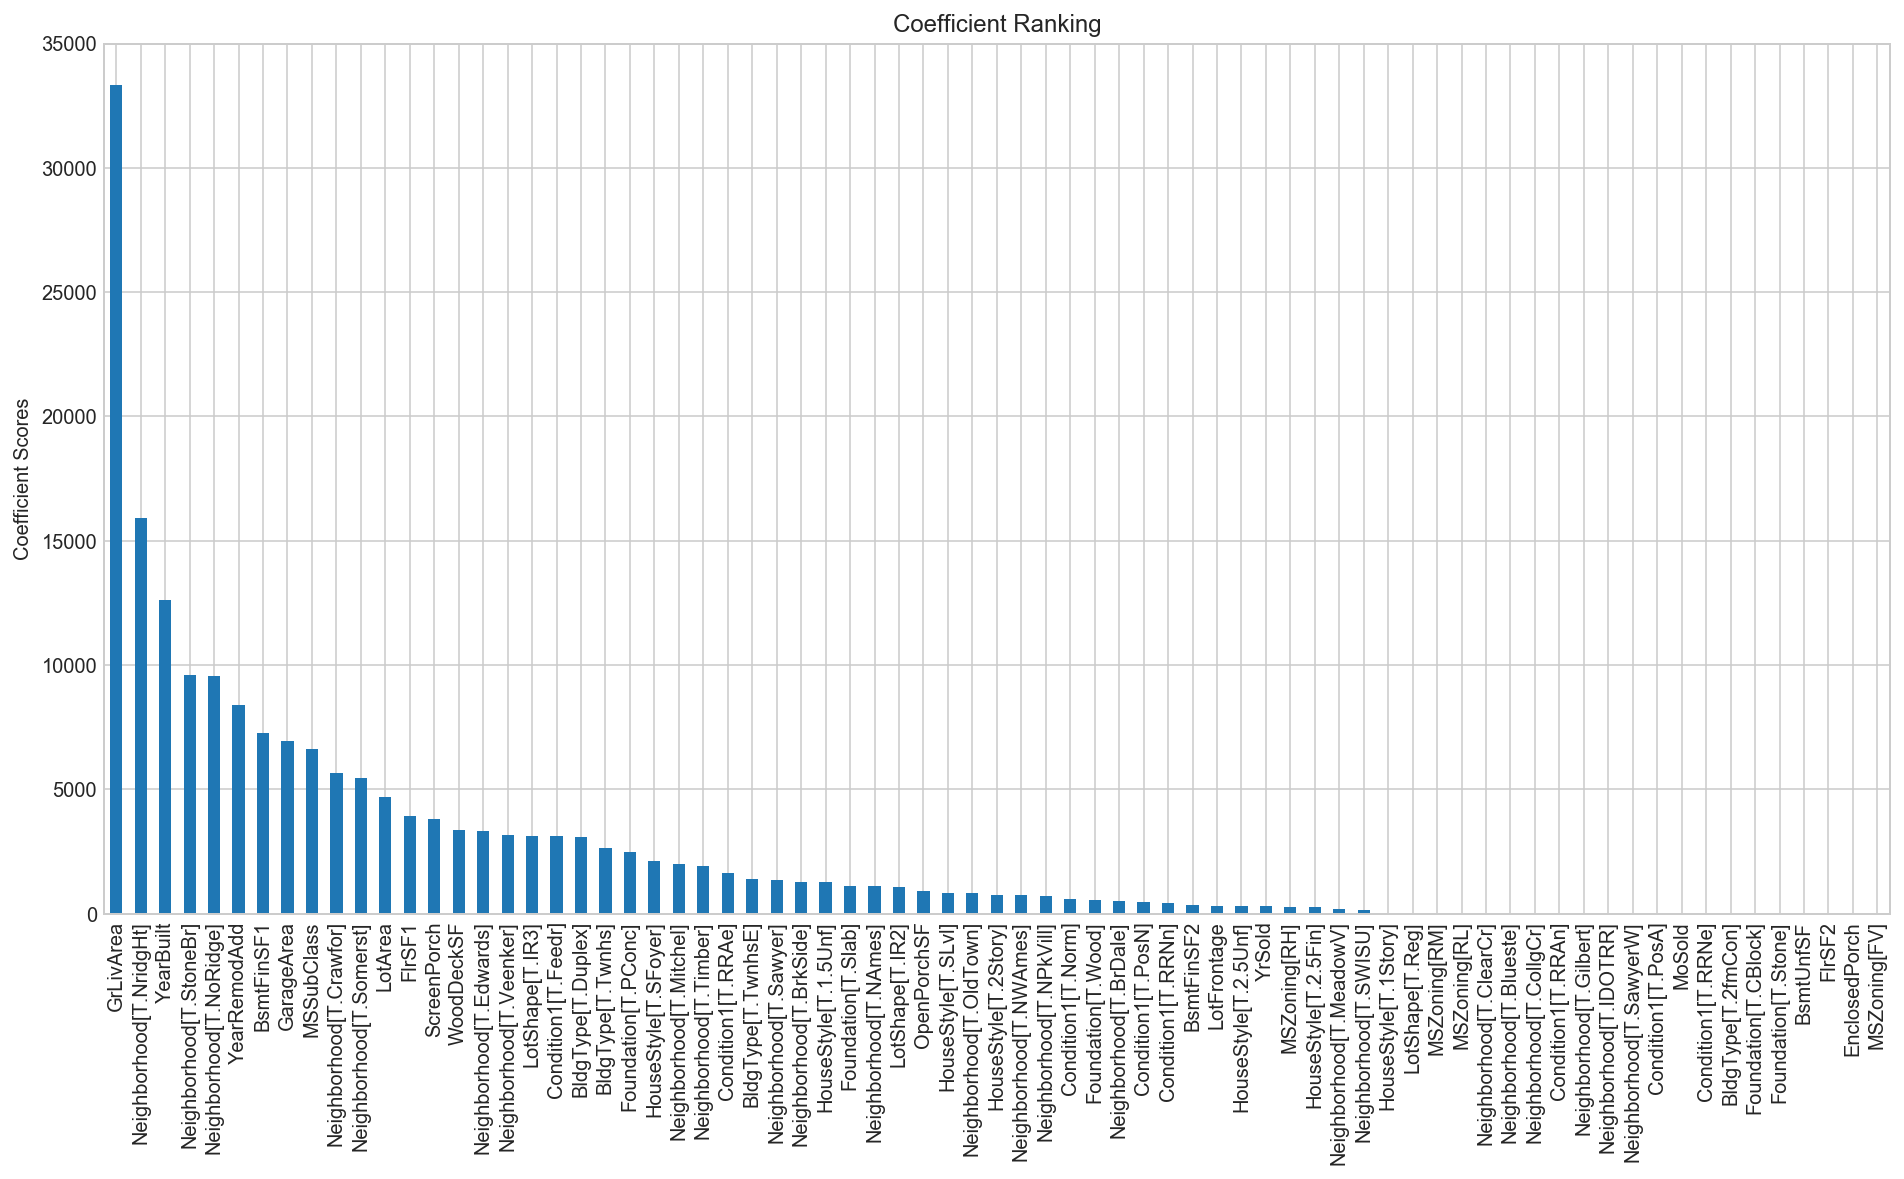

In [209]:
fig, ax = plt.subplots(figsize=(16,8))
lasso_coefs.plot(kind='bar', title='Coefficient Ranking', ax=ax)
plt.ylabel('Coefficient Scores')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

###  Use renovatable features to predict the residuals from the Lasso model for non-renovatable features

In [210]:
f_reno = 'SalePrice ~ '+' + '.join([c for c in df_renovatable.columns if not c == 'SalePrice']) + ' -1'
print f_reno
_, X_reno = patsy.dmatrices(f_reno, data=df_renovatable, return_type='dataframe')
print X_reno.shape

SalePrice ~ LotConfig + OverallQual + OverallCond + RoofStyle + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + ExterQual + ExterCond + BsmtQual + BsmtExposure + BsmtFinType1 + HeatingQC + CentralAir + Electrical + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenQual + Fireplaces + GarageType + GarageFinish + GarageCars + GarageQual + GarageCond + PavedDrive -1
(1450, 106)


#### Target variable: Predicted price - Sale price(yhat - y) 

In [211]:
X_reno_train = X_reno.loc[house['YrSold'] != 2010,:]
X_reno_test = X_reno.loc[house['YrSold'] == 2010, :]
y_resid_train = y_fixed_train - lasso.predict(Xs_train)
y_resid_test = y_fixed_test - lasso.predict(Xs_test)

### Use the Lasso regression model.

In [212]:
ss=StandardScaler()
Xs_reno_train = ss.fit_transform(X_reno_train)
Xs_reno_test = ss.fit_transform(X_reno_test)

lasso = LassoCV(n_alphas=100).fit(Xs_reno_train, y_resid_train)

yhat = lasso.predict(Xs_reno_test)

metrics.r2_score(y_resid_test, yhat)

0.17315512989820314

Text(0,0.5,u'Coefficient Scores')

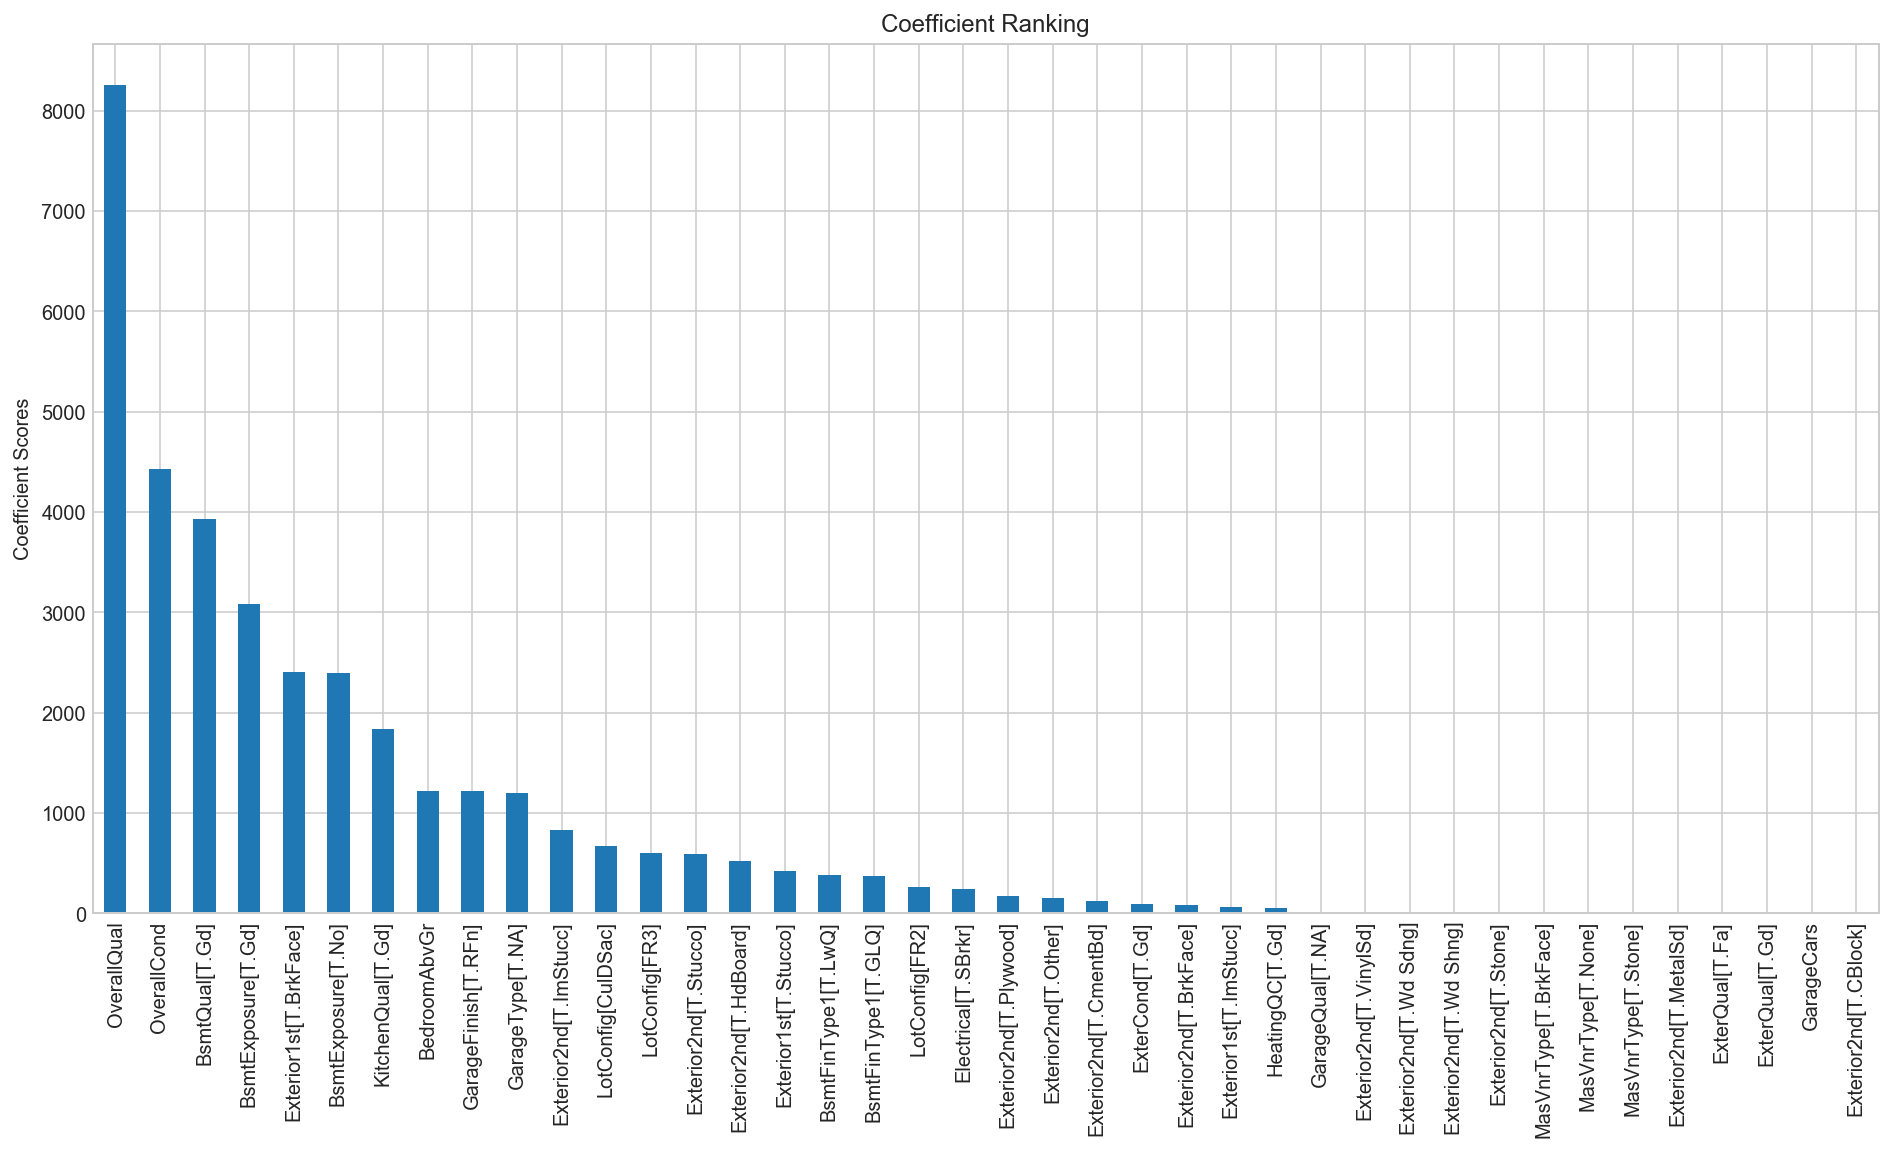

In [213]:
lasso.fit(Xs_reno_train, y_resid_train)
lasso_coefs = pd.Series(np.abs(lasso.coef_), X_reno_train.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16,8))
lasso_coefs.head(40).plot(kind='bar', title='Coefficient Ranking', ax=ax)
plt.ylabel('Coefficient Scores')

###  The renovatable features explains 17% of the variance. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [217]:
house_new = pd.concat((df, df_renovatable), axis=1)
house_new.shape

(1450, 56)

In [218]:
house_new = pd.merge(house_new, house[["SaleCondition"]], left_index=True, right_index=True)

In [219]:
house_new['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [239]:
# Baseline of each class
house_new['SaleCondition'].value_counts() / house_new['SaleCondition'].value_counts().sum()

Normal     0.823448
Partial    0.086207
Abnorml    0.066207
Family     0.013793
Alloca     0.007586
AdjLand    0.002759
Name: SaleCondition, dtype: float64

In [240]:
# Baseline Accuracy
house_new['SaleCondition'] = house_new['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)

In [241]:
house_new['SaleCondition'].value_counts()

0    1354
1      96
Name: SaleCondition, dtype: int64

In [223]:
house['SaleCondition'].value_counts() / house['SaleCondition'].value_counts().sum()

0    0.933793
1    0.066207
Name: SaleCondition, dtype: float64

In [242]:
house_new = house_new.rename(columns = {'1stFlrSF':'O1stFlrSF', '2ndFlrSF':'O2ndFlrSF' , '3SsnPorch':'O3SsnPorch'})

In [264]:
f= 'SaleCondition ~ '+' + '.join([c for c in house_new.columns if not c == 'SaleCondition']) + ' -1'
print f
y, X = patsy.dmatrices(f, data=house_new, return_type='dataframe')
y = y.values.ravel()

print X.shape, y.shape

SaleCondition ~ MSSubClass + MSZoning + LotFrontage + LotArea + LotShape + Neighborhood + Condition1 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + FlrSF1 + FlrSF2 + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + MoSold + YrSold + SalePrice + LotConfig + OverallQual + OverallCond + RoofStyle + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + ExterQual + ExterCond + BsmtQual + BsmtExposure + BsmtFinType1 + HeatingQC + CentralAir + Electrical + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenQual + Fireplaces + GarageType + GarageFinish + GarageCars + GarageQual + GarageCond + PavedDrive + SalePrice -1
(1450, 180) (1450,)


## Approaches to handle Imbalanced Classification Problems

#### Resampling Techniques
1. Random Under-Sampling
    - I won't use this method because it leads to information loss
2. Random Over-Sampling
    - Outperforms under sampling, but increases the likelihood of overfitting since it replicates the minority class events
3. Synthetic Minority Over-sampling Technique (SMOTE) --> I will try this method
    - Only oversamples the minority class
    - Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
4. SMOTEEN --> I will try this method

#### Algorithmic Ensemble Techniques
1. Cost-Sensitive Training 
2. Bagging Based
3. Boosting-Based
    - Ada Boost
    - XGBoost (Extreme Gradient Boosting)
    
##### Area Under ROC Curve (AUROC) will not be used as a performance metrics for evaluating the models because of the imbalanced dataset
##### I will evaluate the models based on Recall scores

#### Fit the following classifiers on model using the training dataset:
- Random Forest Classifier
- LinearSVC 
- Logistic Regression

In [315]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=12)

In [377]:
def print_cm_cr(y_test, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print confusion
    print
    print classification_report(y_test, y_pred)

In [370]:
def param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [365]:
def classifier_fit_predict(classifier, X_train, y_train):

    clf = classifier.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print_cm_cr(y_test, y_pred)

## SMOTE

### Classify using SMOTE and Logistic Regression

In [358]:
smote = SMOTE(random_state=2, ratio = 'minority')
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [357]:
classifier_fit_predict(LogisticRegression(), X_train_smote, y_train_smote)

Predicted  0.0  1.0  All
Actual                  
0.0        281  167  448
1.0         11   20   31
All        292  187  479

             precision    recall  f1-score   support

        0.0       0.96      0.63      0.76       448
        1.0       0.11      0.65      0.18        31

avg / total       0.91      0.63      0.72       479



### Classify using SMOTE and Support Vector Machine

In [371]:
parameters = param_selection(X_train_smote, y_train_smote, 3)

In [372]:
svc = SVC(C= parameters['C'], gamma = parameters['gamma'] )

In [378]:
classifier_fit_predict(svc, X_train_smote, y_train_smote)

Predicted  0.0  1.0  All
Actual                  
0.0        449    0  449
1.0          9   21   30
All        458   21  479

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       449
        1.0       1.00      0.70      0.82        30

avg / total       0.98      0.98      0.98       479



## SMOTEENN

### Classify using SMOTEENN and Logistic Regression

In [322]:
smoteenn = SMOTEENN(random_state=2)
X_train_smoteen, y_train_smoteen = smoteenn.fit_sample(X_train, y_train)

In [323]:
classifier_fit_predict(LogisticRegression(), X_train_smoteen, y_train_smoteen)

Predicted  0.0  1.0  All
Actual                  
0.0        240  208  448
1.0          7   24   31
All        247  232  479

             precision    recall  f1-score   support

        0.0       0.97      0.54      0.69       448
        1.0       0.10      0.77      0.18        31

avg / total       0.92      0.55      0.66       479



### Classify using SMOTEENN and Support Vector Machine

In [374]:
parameters = param_selection(X_train_smoteen, y_train_smoteen, 3)

In [375]:
svc = SVC(C= parameters['C'], gamma = parameters['gamma'] )

In [379]:
classifier_fit_predict(svc, X_train_smoteen, y_train_smoteen)

Predicted  0.0  1.0  All
Actual                  
0.0        140  309  449
1.0          0   30   30
All        140  339  479

             precision    recall  f1-score   support

        0.0       1.00      0.31      0.48       449
        1.0       0.09      1.00      0.16        30

avg / total       0.94      0.35      0.46       479



### Future work...
- Explore other techniques to handle imbalanced datasets
- Tune the parameters of the classifier
- Plotting SMOTE and SMOTEEN results